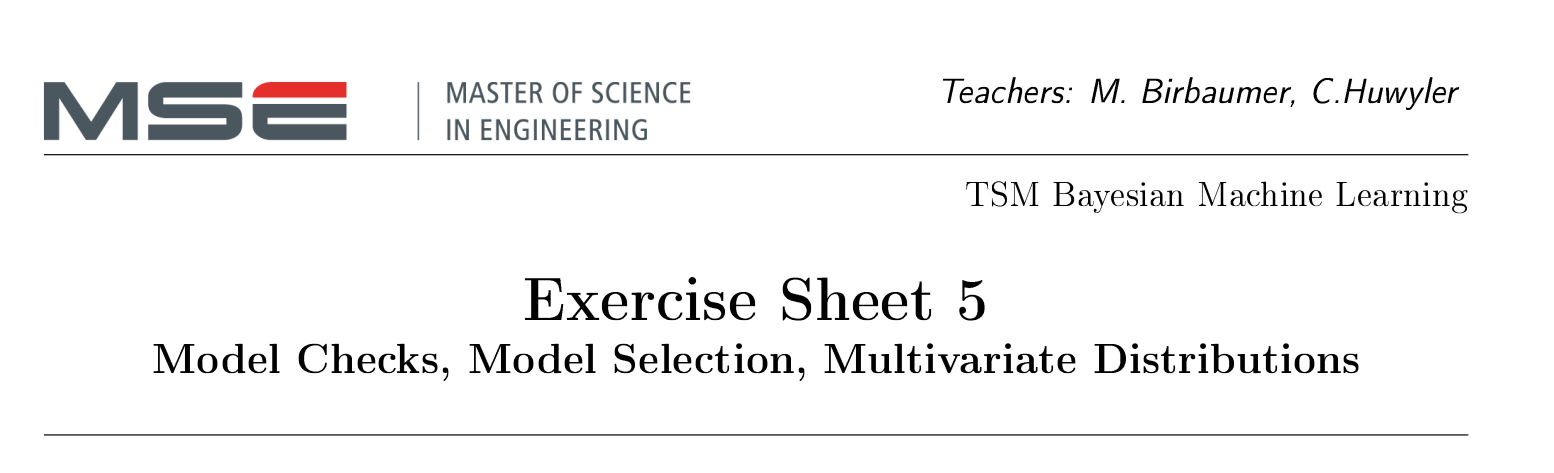

# Solutions

Import necessary libraries:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import preliz as pz
from tqdm.auto import tqdm
import pymc as pm
plt.rcParams["figure.figsize"] = (15,3)
plt.style.use('ggplot')
np.random.seed(1337) # for consistency

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Exercise 1

Data:

In [2]:
y_obs = np.load( "toilet_paper_data.npy" )
y_obs

array([165.5, 138.7, 139.7, 133.1, 156.4, 118.4, 166.9, 136.9, 149.8,
       143. , 163.5, 121.3, 142.1, 141.4, 159.6, 132.8, 143.9, 135.5,
       146.5, 153. , 132.8, 159.7, 156.8, 152. , 156.8, 137.8, 144.5,
       134.8, 142.8, 152.4, 137.7, 141.2, 137.8, 135.9, 137.9, 145.8,
       132.6, 148.8, 165.9, 154.9, 220. , 135.3, 137. , 166.3, 146.6,
       138.4, 148.3, 171.2, 147.4, 153.4, 149.6, 141.8, 132.3])

### a)

Empirical mean and standard deviation:

In [3]:
ybar = np.mean(y_obs)
sigmahat = np.std(y_obs, ddof=1)

Simulation:

In [4]:
with pm.Model() as tp_model_normal:
    μ = pm.Normal( 'μ', mu=ybar, sigma=sigmahat )
    σ = pm.Exponential( 'σ', lam=1/sigmahat )
    y = pm.Normal( 'y', mu=μ, sigma=σ, observed=y_obs )
    trace_normal = pm.sample( 1000 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Marginal distributions and HDIs:

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

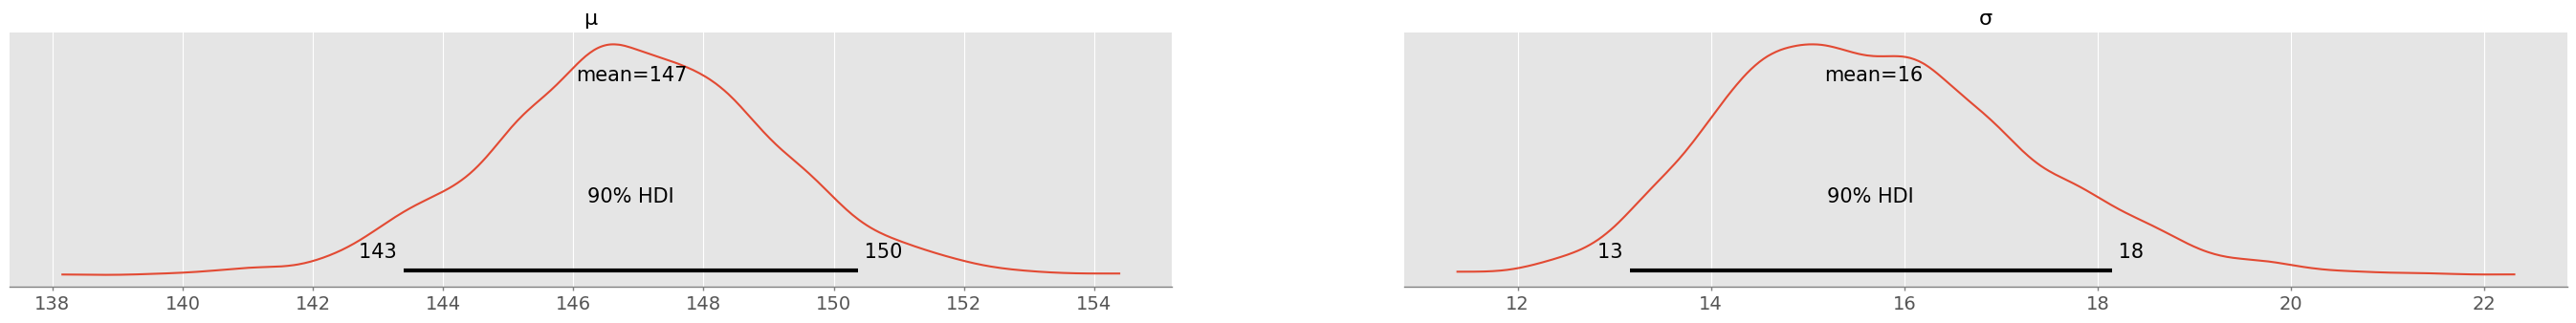

In [5]:
pm.plot_posterior( trace_normal, hdi_prob=0.9 )

In [6]:
pm.summary( trace_normal, hdi_prob=0.9 )

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,146.889,2.129,143.389,150.369,0.034,0.024,4043.0,2947.0,1.0
σ,15.685,1.553,13.157,18.146,0.027,0.019,3476.0,2704.0,1.0


With 90% plausibility, $\mu$ is between 143-150 and $\sigma$ is between 13 and 18. After a full year of data there is quite some (aleatoric) uncertainty remaining!

### b)

array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

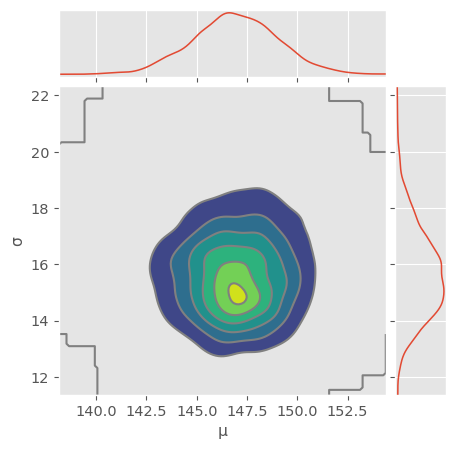

In [7]:
pm.plot_pair( trace_normal, kind="kde", figsize=(5,5), marginals=True )

Looks normally distributed! Note that variances are not equal and you should actually see an ellipse if you turn on equal aspect ratio.

In [8]:
data = np.hstack( [trace_normal.posterior.μ.values.flatten().reshape(-1,1), trace_normal.posterior.σ.values.flatten().reshape(-1,1)] )
np.cov( data.T )

array([[4.53371196, 0.01404761],
       [0.01404761, 2.41272752]])

Covariance matrix is almost diagonal! That means there are almost no correlations between $\mu$ and $\sigma$ also in the posterior!

### c)

Compute predictions:

In [9]:
with tp_model_normal:
    ppc_normal = pm.sample_posterior_predictive(trace_normal)

Sampling: [y]


Output()

Reshape predictions for broadcasting with Numpy:

In [10]:
ypred_normal = ppc_normal.posterior_predictive.y.values.reshape(-1,53)
ypred_normal.shape

(4000, 53)

Compute differences:

In [11]:
eps_normal = ypred_normal - y_obs

RMSE (in kg):

In [12]:
np.sqrt( np.mean( eps_normal**2 ) )

22.10692417845692

MAE (in kg):

In [13]:
np.mean( np.abs( eps_normal ) )

16.85346110873668

RMSE and MAE are quite different, this could indicate the presence of an outlier in the data..

### d)

<Axes: xlabel='y'>

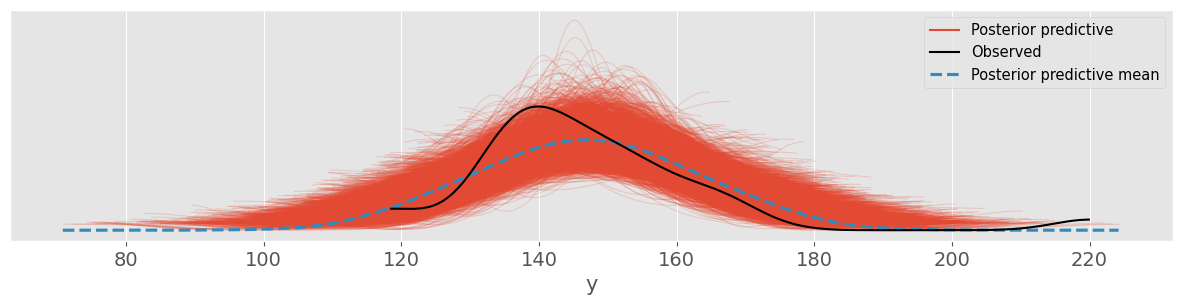

In [14]:
pm.plot_ppc( ppc_normal )

The predictions (red) closely follow a normal distribution. However, the center of the observed data distribution is more to the left! There is an outlier present that can be quickly found (using e.g. a strip plot from seaborn):

<Axes: >

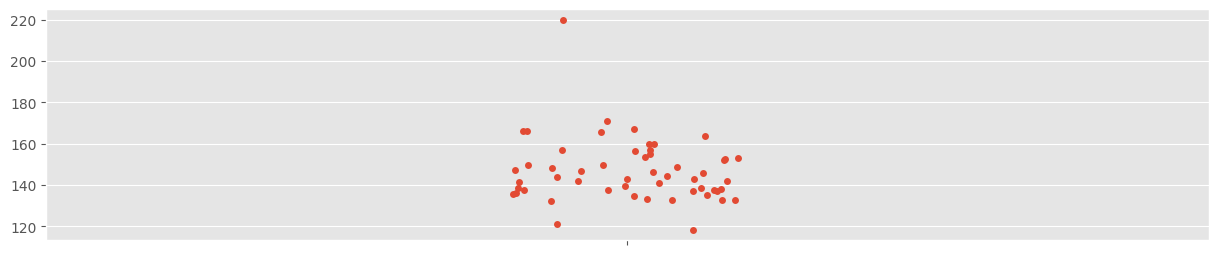

In [15]:
sns.stripplot( y_obs )

This outlier appears to pull the estimate for $\mu$ a bit towards the right. This has not much influence on the estimated mean, but quite some on the estimated standard deviation:

In [16]:
np.std( y_obs, ddof=1 ), np.std( y_obs[y_obs<200], ddof=1 )

(15.44934205108168, 11.683511702453055)

## Exercise 2

### a)

(-4.0, 4.0)

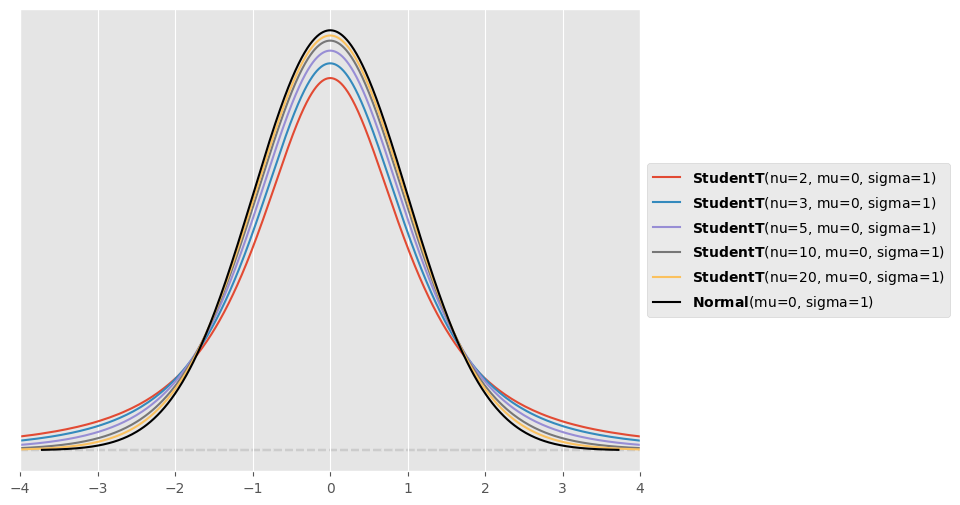

In [17]:
plt.figure( figsize=(8,6) )
for nu in [2,3,5,10,20]:
    pz.StudentT( mu=0, sigma=1, nu=nu ).plot_pdf()
pz.Normal( mu=0, sigma=1 ).plot_pdf( color="black" )
plt.xlim([-4,4])

The Student's $t$ distribution converges towards the normal distribution for large values of $\nu$ (so in theory for $\nu \to \infty$). For smaller values of $\nu$, the Student's $t$ distribution has fatter tails than the normal distribution.

### b)

Prior for $\nu$:

<Axes: >

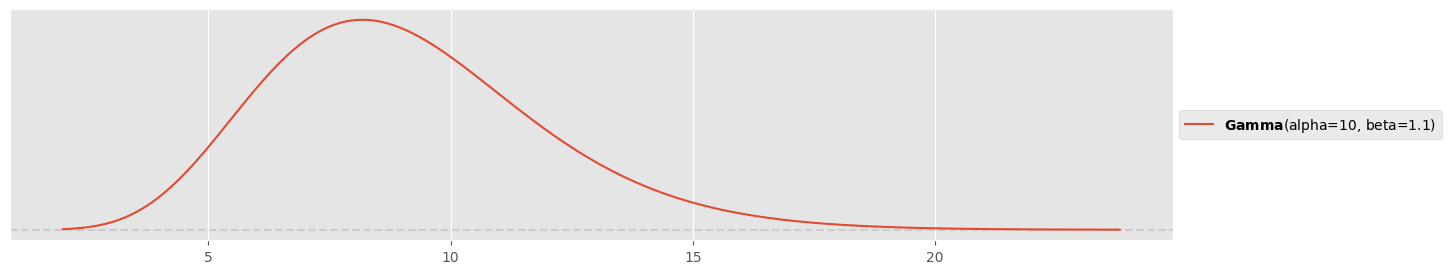

In [18]:
pz.Gamma(10,1.1).plot_pdf()

Simulation:

In [19]:
with pm.Model() as tp_model_studentt:
    μ = pm.Normal( 'μ', mu=ybar, sigma=sigmahat )
    σ = pm.Exponential( 'σ', lam=1/sigmahat )
    ν = pm.Gamma( 'ν', alpha=10, beta=1.1 )
    y = pm.StudentT( 'y', mu=μ, sigma=σ, nu=ν, observed=y_obs )
    trace_studentt = pm.sample( 1000 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ν]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'ν'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

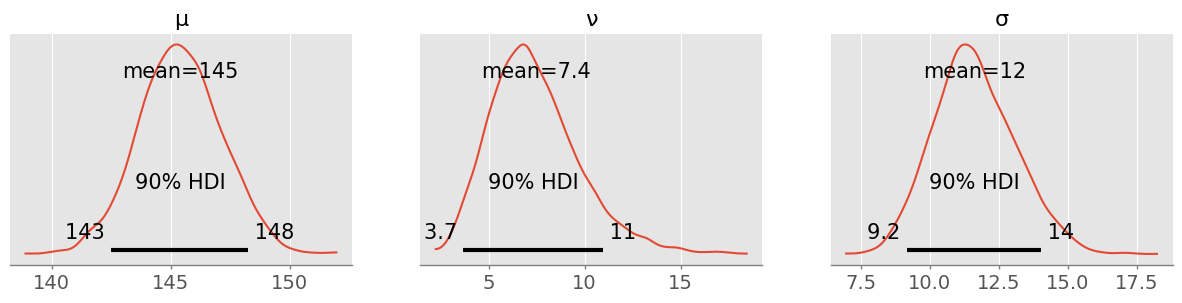

In [20]:
pm.plot_posterior( trace_studentt, figsize=(15,3), hdi_prob=0.9 )

There is slightly less uncertainty in the mean $\mu$ and considerable less uncertainty in $\sigma$ (that was by definition heavily influenced by the outlier)! $\nu$ is with 90% plausibility between 4 and 11, a considerable difference to a normal distribution with fatter tails:

(-4.0, 4.0)

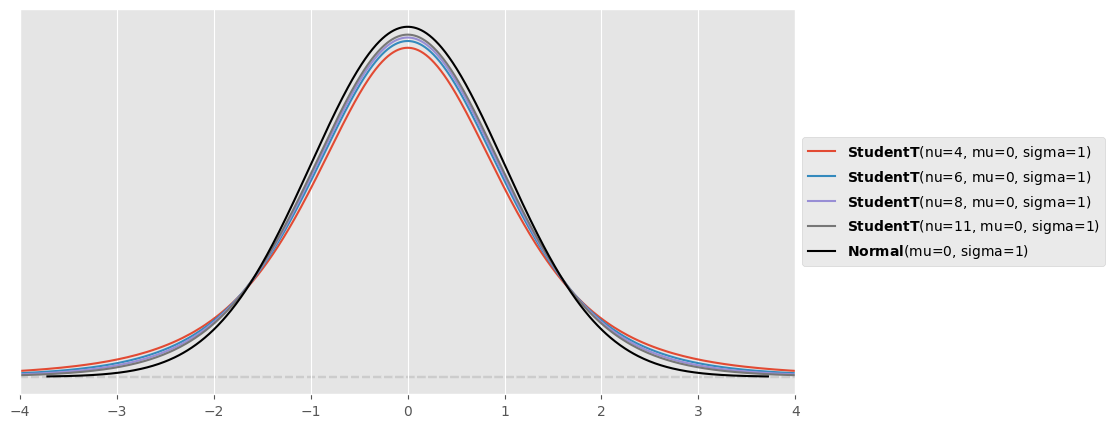

In [21]:
plt.figure( figsize=(10,5) )
for nu in [4,6,8,11]:
    pz.StudentT( mu=0, sigma=1, nu=nu ).plot_pdf()
pz.Normal( mu=0, sigma=1 ).plot_pdf( color="black" )
plt.xlim([-4,4])

The fatter tails allow to accomodate the outlier there, while the normal distribution tries to bring the outlier more within its center.

### c)

In [22]:
with tp_model_studentt:
    ppc_studentt = pm.sample_posterior_predictive(trace_studentt)

Sampling: [y]


Output()

Text(0.5, 1.0, "Student's t likelihood")

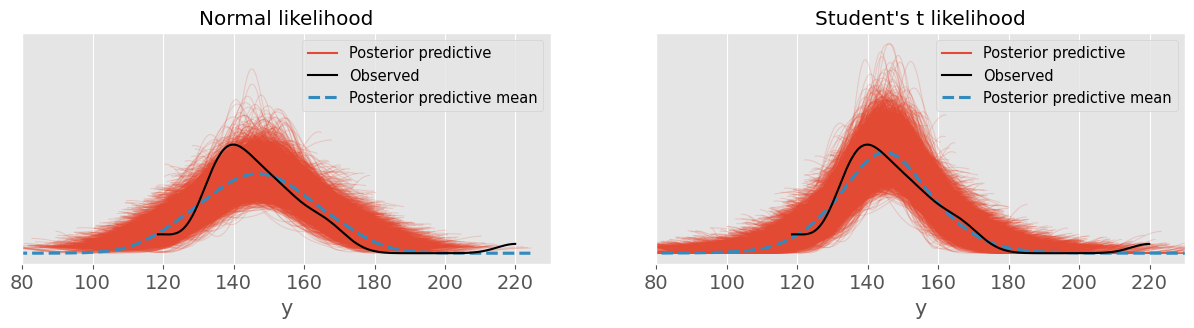

In [23]:
fig, ax = plt.subplots(1, 2, sharey=True )
plt.sca( ax[0] )
pm.plot_ppc( ppc_normal, ax=ax[0] )
plt.xlim(80, 230)
plt.title("Normal likelihood")
plt.sca( ax[1] )
pm.plot_ppc( ppc_studentt, ax=ax[1] )
plt.xlim(80, 230)
plt.title("Student's t likelihood")

Student's $t$ likelihood seems to make predictions quite a bit closer to the data distribution!

### d)

In [24]:
ypred_studentt = ppc_studentt.posterior_predictive.y.values.reshape(-1,53)
eps_studentt = ypred_studentt - y_obs

RMSE:

In [25]:
np.sqrt( np.mean( eps_studentt**2 ) )

20.915728837756145

MAE:

In [26]:
np.mean( np.abs( eps_studentt ) )

15.430312325683945

RMSE and MAE are now of almost equal size. However they are only a bit smaller. Choosing a more complex distribution (3 instead of 2 parameters) comes with more uncertainty in the parameters and consequently more predictive uncertainty for the same amount of data. Even though we have reduced the bias of the model ('wrong' normal likelihood assumption), we have now increased its variance by introducing an additional parameter.

### e)

In [27]:
with tp_model_normal:
    pm.compute_log_likelihood(trace_normal)
loo_normal = pm.loo( trace_normal )

Output()

/home/chuwyler/.local/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


(this warning is justified!!)

In [28]:
with tp_model_studentt:
    pm.compute_log_likelihood(trace_studentt)
loo_studentt = pm.loo( trace_studentt )

Output()

In [29]:
df_comp_loo = pm.compare({'Normal Likelihood': loo_normal, 'Student\'s t Likelihood': loo_studentt})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Student's t Likelihood,0,-216.130381,2.779683,0.000000,1.000000e+00,8.981762,0.000000,False,log
Normal Likelihood,1,-224.590306,6.029040,8.459926,1.509903e-14,14.347303,6.494544,True,log


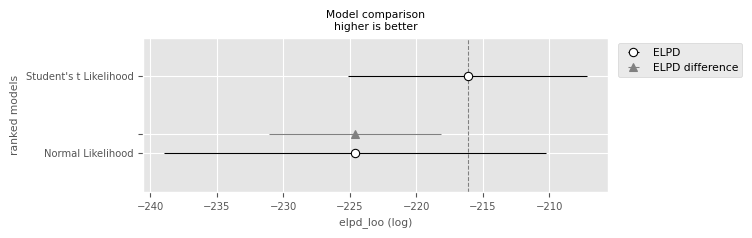

In [30]:
pm.plot_compare(df_comp_loo);

In terms of ELPD, the model with the Student's $t$ likelihood is not significantly better (by the one-standard-error rule) than the model with the normal likelihood. This would probably change with more data and is due to the additional uncertainties (e.g. in the estimation of $\nu$).

## Exercise 4

Data:

In [31]:
y_obs = np.load( "railway_switch_data.npy" )

### a) 

#### Poisson likelihood model:

<Axes: >

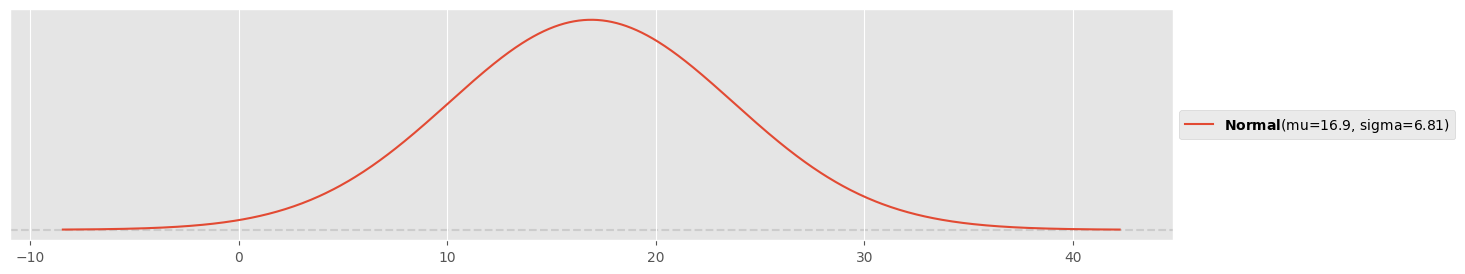

In [32]:
pz.Normal( mu=np.mean(y_obs), sigma=np.std(y_obs) ).plot_pdf()

In [33]:
with pm.Model() as poisson_model:
    lbd = pm.Normal( 'lbd', mu=np.mean(y_obs), sigma=np.std(y_obs) )
    y = pm.Poisson( 'y', mu=lbd, observed=y_obs )
    trace_poisson = pm.sample( 1000, chains=4 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lbd]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: title={'center': 'lbd'}>

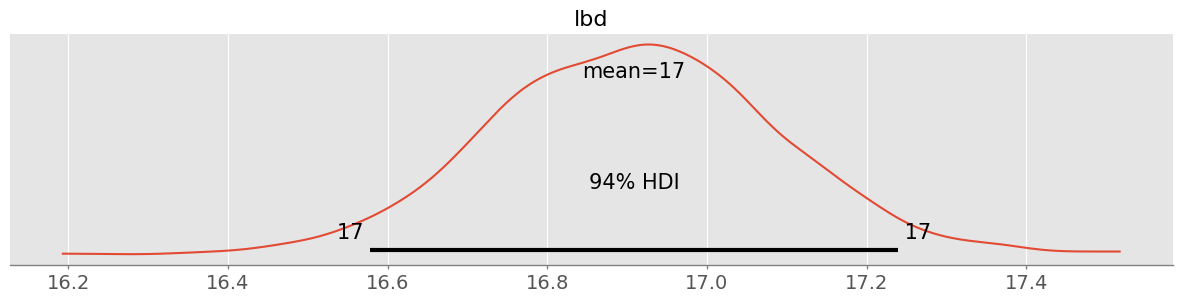

In [34]:
pm.plot_posterior( trace_poisson )

#### Negative binomial likelihood model:

<Axes: >

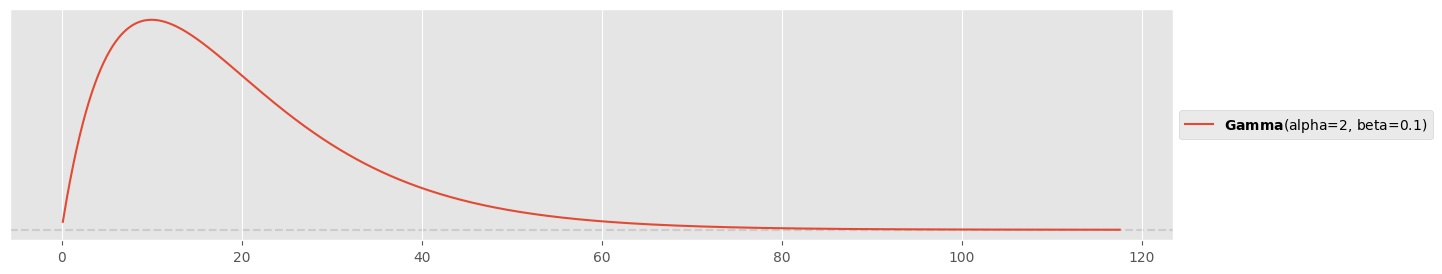

In [35]:
pz.Gamma( alpha=2, beta=0.1 ).plot_pdf()

In [36]:
with pm.Model() as negbin_model:
    lbd = pm.Normal( 'lbd', mu=np.mean(y_obs), sigma=np.std(y_obs) )
    r = pm.Gamma( 'alpha', alpha=2, beta=0.1 )
    y = pm.NegativeBinomial( 'y', mu=lbd, alpha=r, observed=y_obs )
    trace_negbin = pm.sample( 1000, chains=4 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lbd, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'lbd'}>],
      dtype=object)

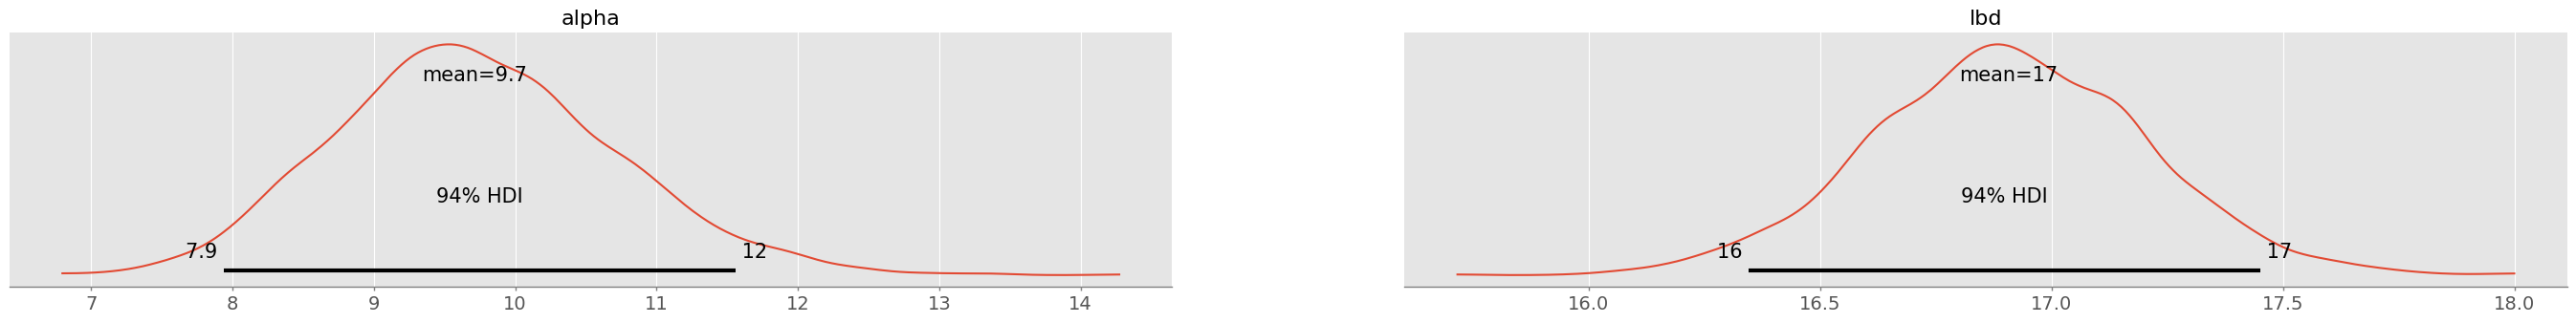

In [37]:
pm.plot_posterior( trace_negbin )

<Axes: xlabel='alpha', ylabel='lbd'>

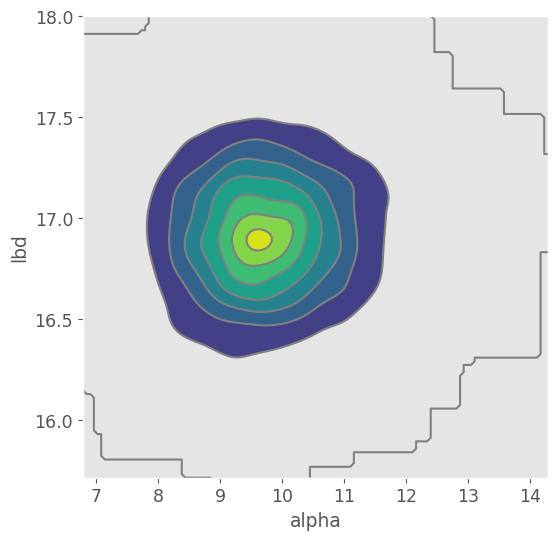

In [38]:
pm.plot_pair( trace_negbin, kind="kde", figsize=(6,6) )

Again the joint posterior distribution looks normally distributed!

### b)

Posterior predictions:

In [39]:
with poisson_model:
    ppc_poisson = pm.sample_posterior_predictive(trace_poisson)

with negbin_model:
    ppc_negbin = pm.sample_posterior_predictive(trace_negbin)

Sampling: [y]


Output()

Sampling: [y]


Output()

Posterior predictive checks:

Text(0.5, 1.0, 'Negative binomial likelihood')

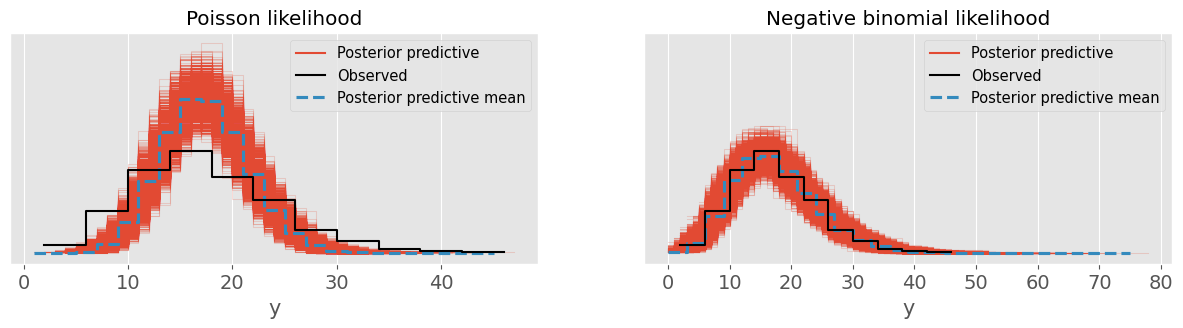

In [40]:
fig, ax = plt.subplots(1, 2, sharey=True )
plt.sca( ax[0] )
pm.plot_ppc( ppc_poisson, ax=ax[0] )
plt.title("Poisson likelihood")
plt.sca( ax[1] )
pm.plot_ppc( ppc_negbin, ax=ax[1] )
plt.title("Negative binomial likelihood")

The negative binomial likelihood seems much better suited to model the data!

### c)

In [41]:
with poisson_model:
    pm.compute_log_likelihood(trace_poisson)
loo_poisson = pm.loo( trace_poisson )

Output()

In [42]:
with negbin_model:
    pm.compute_log_likelihood(trace_negbin)
loo_negbin = pm.loo( trace_negbin )

Output()

In [43]:
df_comp_loo = pm.compare({'Poisson Likelihood': loo_poisson, 'Negative Binomial Likelihood': loo_negbin})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Negative Binomial Likelihood,0,-1753.580085,2.090300,0.00000,0.997772,16.804076,0.000000,False,log
Poisson Likelihood,1,-1944.821755,2.716269,191.24167,0.002228,44.241842,28.130826,False,log


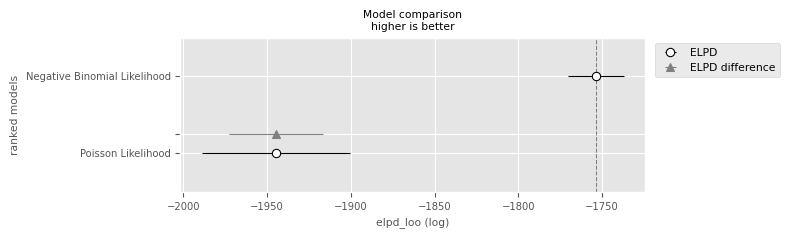

In [44]:
pm.plot_compare(df_comp_loo);

Clearly it is recommended to use the negative binomial model! This time we have enough data to reduce the uncertainty of the additional parameter.

### d)

In [45]:
ypred_poisson = ppc_poisson.posterior_predictive.y.values.reshape(-1,530)
ypred_negbin = ppc_negbin.posterior_predictive.y.values.reshape(-1,530)
eps_poisson = ypred_negbin - y_obs
eps_negbin = ypred_poisson - y_obs

RMSE:

In [46]:
rmse_poisson = np.sqrt( np.mean( eps_poisson**2 ) )
rmse_negbin = np.sqrt( np.mean( eps_negbin**2 ) )
rmse_poisson, rmse_negbin

(9.652519614362893, 7.958594292537316)

MAE:

In [47]:
mae_poisson = np.mean( np.abs( eps_poisson ) )
mae_negbin = np.mean( np.abs( eps_negbin ) )
mae_poisson, mae_negbin

(7.594799056603773, 6.290791037735849)

Both negative binomial RMSE and MAE are a bit smaller!

## Exercise 4

### a)

In [48]:
observed_counts = [82, 24, 6]

rng = np.random.default_rng(123)

with pm.Model() as churn_model:
    pi = pm.Dirichlet( 'pi', a=[1,1,1] )
    y = pm.Multinomial( 'y', n=np.sum(observed_counts), p=pi, observed=observed_counts )
    trace = pm.sample(1000, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


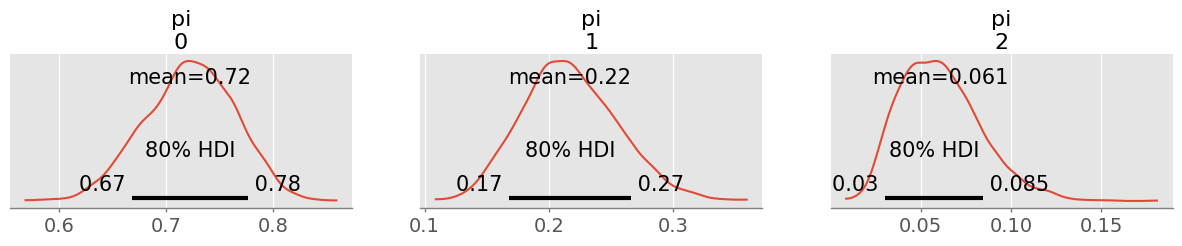

In [49]:
pm.plot_posterior( trace, figsize=(15,2), hdi_prob=0.8 );

I believe to 90% that for around 67-78% of the churn customers the premium is too high, for around 17-27% the coverage was unsufficient and around 0.03-0.09% found our insurance models unsuitable.

### b)

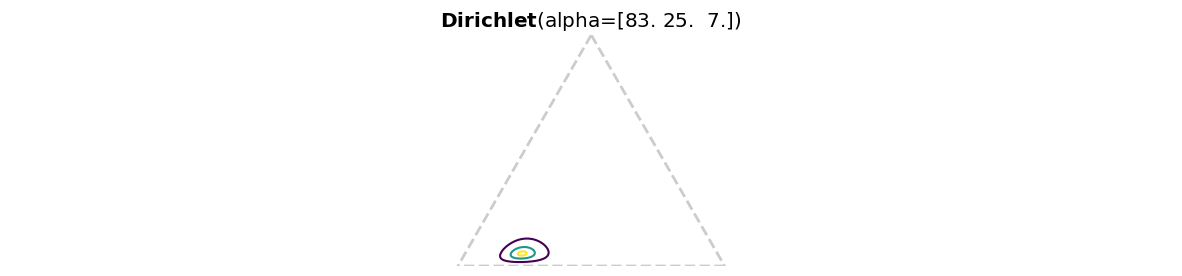

In [50]:
alpha = np.array([1,1,1])
pz.Dirichlet( alpha + observed_counts ).plot_pdf( marginals=False )

### c)

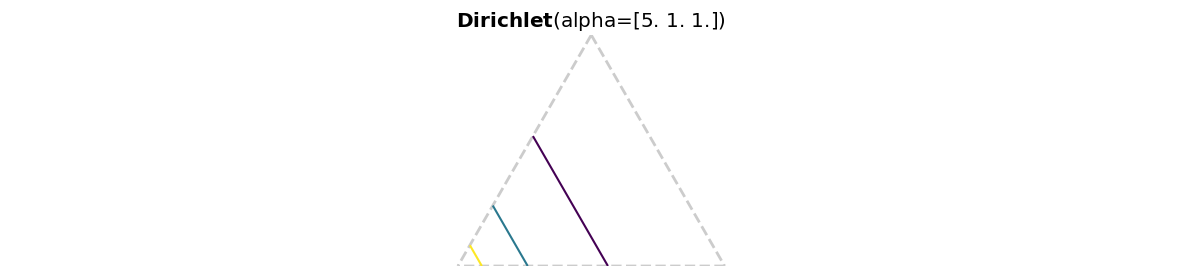

In [51]:
pz.Dirichlet( [5,1,1] ).plot_pdf( marginals=False )

/home/chuwyler/.local/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:287: RuntimeWarning: divide by zero encountered in nb_logpdf
  return super().__call__(*args, **kws)


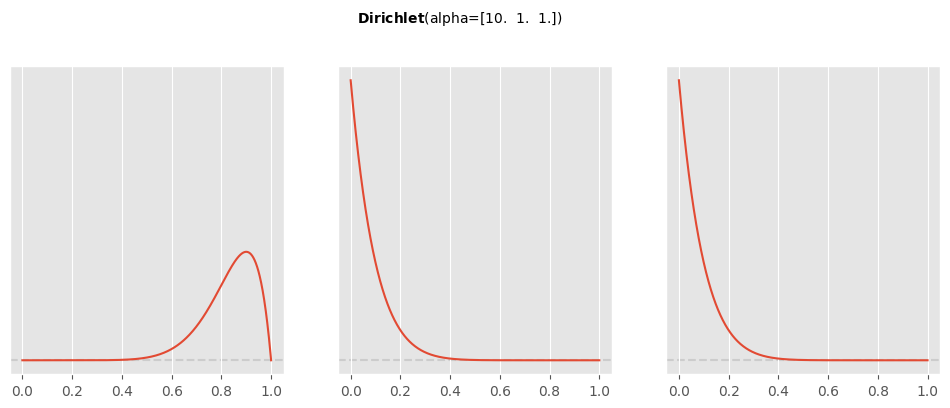

In [52]:
pz.Dirichlet( [10,1,1] ).plot_pdf()

In [53]:
pz.Dirichlet( [10,1,1] ).summary()

Dirichlet(mean=array([0.83333333, 0.08333333, 0.08333333]), std=array([0.10336228, 0.07665552, 0.07665552]))

In [54]:
with pm.Model() as churn_model:
    pi = pm.Dirichlet( 'pi', a=[10,1,1] )
    y = pm.Multinomial( 'y', n=np.sum(observed_counts), p=pi, observed=observed_counts )
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


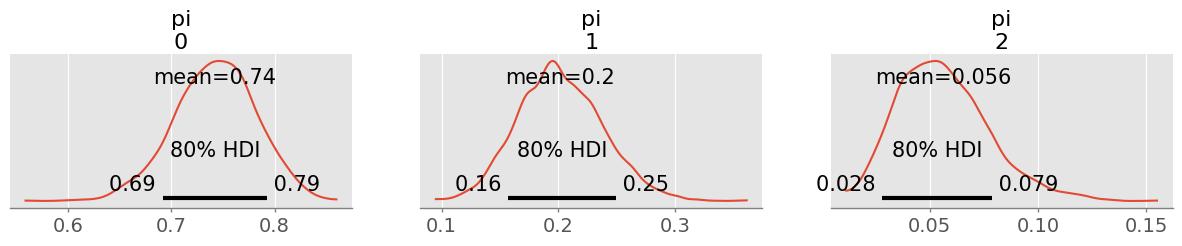

In [55]:
pm.plot_posterior( trace, figsize=(15,2), hdi_prob=0.8 );

90% HDIs are only changed by a few percent! This will not have a big impact on my communication.

## Exercise 5

### a) 

Load data and standardize:

In [56]:
credit_data = pd.read_csv("credit_data.csv")
credit_data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [57]:
credit_data = credit_data[['Income', 'Rating']]
means = credit_data.mean()
stds = credit_data.std()
credit_data_scaled = (credit_data - means) / stds

### b)

Run posterior simulation:

In [58]:
with pm.Model() as mv_normal_model:
    # Prior for the mean (should be around zero!) - assume a lot of (symmetric) covariance
    mean = pm.MvNormal('mean', mu=0, cov=[[1,0],[0,1]] )

    # Prior for standard deviations (to rescale the correlation matrix to the covariance matrix)
    sigma_dist = pm.Exponential.dist(1)

    # Prior for the correlation matrix (flat for eta=1, estimating cov through Cholesky decomposition)
    chol, corr, sigmas = pm.LKJCholeskyCov('chol_cov', eta=1, n=2, sd_dist=sigma_dist)
    cov = chol.dot(chol.T)
    cov = pm.Deterministic('cov', cov) # store as variable for later access
    
    # Define the multivariate normal distribution
    y_pred = pm.MvNormal('y_pred', mu=mean, cov=cov, observed=credit_data_scaled[['Income', 'Rating']].values)

    # Perform Bayesian inference 
    # (warm-up phase reduced to 1000 steps, increase the target_accept rate for nuts for better stability)
    trace = pm.sample(draws=2000, chains=4, tune=1000, nuts={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, chol_cov]


Output()

/home/chuwyler/.local/lib/python3.10/site-packages/pytensor/compile/function/types.py:959: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


Diagnostics (only for mean and cov)

array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'mean'}>],
       [<Axes: title={'center': 'cov'}>, <Axes: title={'center': 'cov'}>]],
      dtype=object)

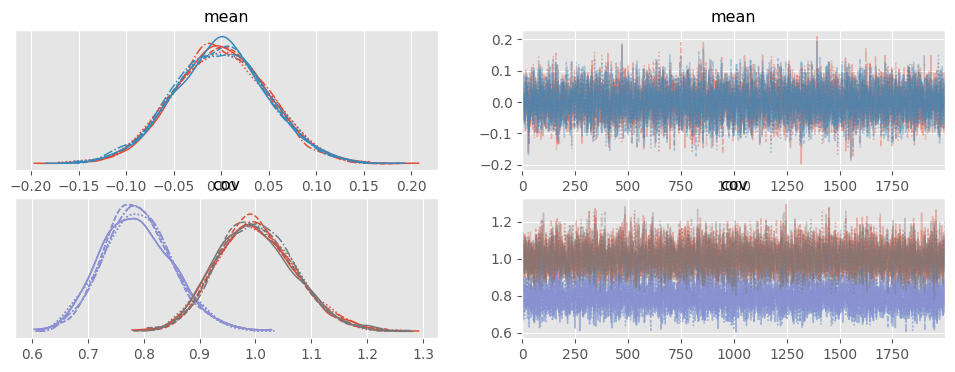

In [59]:
pm.plot_trace( trace, var_names=["mean", "cov"] )

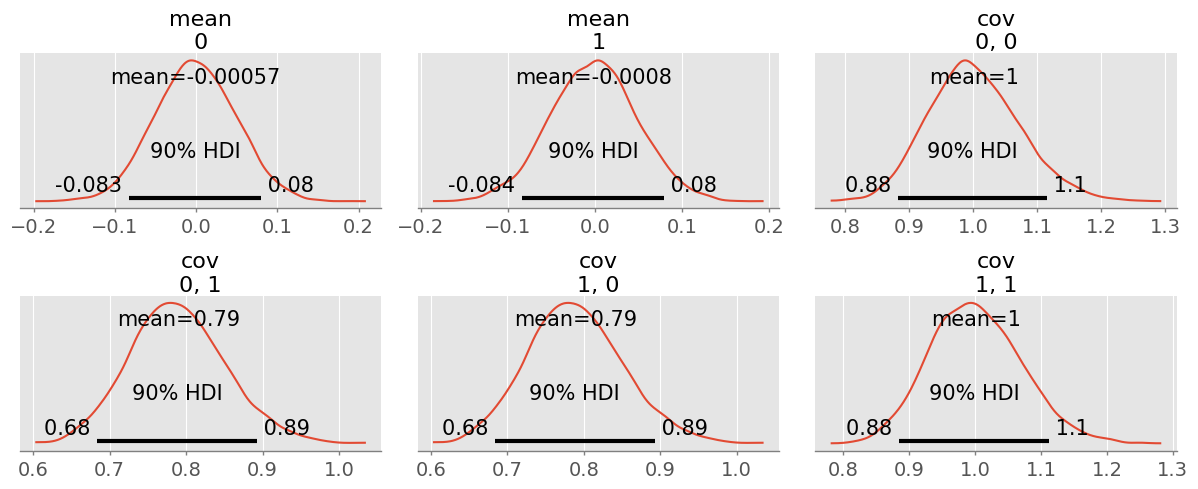

In [60]:
pm.plot_posterior( trace, var_names=["mean", "cov"], figsize=(12,5), hdi_prob=0.9 )
plt.tight_layout()

### c)

Posterior predictive check:

In [61]:
with mv_normal_model:
    ppc = pm.sample_posterior_predictive(trace)

Sampling: [y_pred]


Output()

<Axes: xlabel='y_pred'>

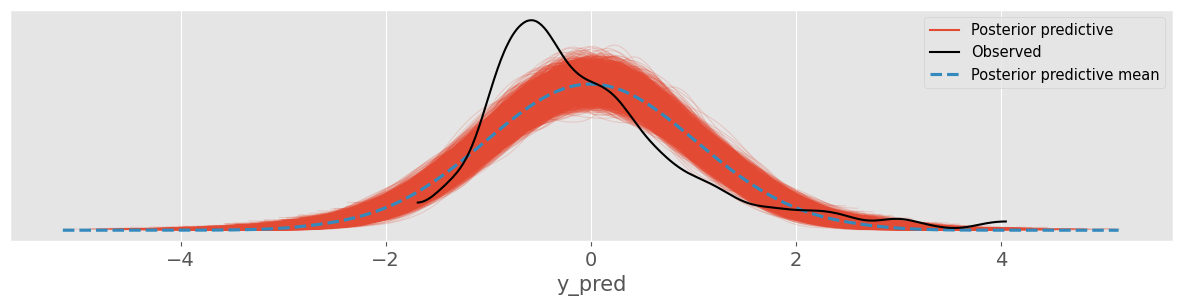

In [62]:
pm.plot_ppc( ppc )

Data are a bit skewed and not really on a normal distribution. Nevertheless we keep our model instead of looking for a skewed variant of the normal distribution.

### d)

Predicted samples:

In [63]:
ppc.posterior_predictive.y_pred.shape

(4, 2000, 400, 2)

Dimensions: chains x samples x observed samples x 2 variables

Select 4000 samples from them:

In [64]:
samples = ppc.posterior_predictive.y_pred.values.reshape(-1,2)
samples.shape

(3200000, 2)

In [65]:
inds = np.random.choice( np.arange( samples.shape[0] ), 4000 )
samples = samples[inds, :]
samples.shape

(4000, 2)

Rescale samples back to original mean + standard deviation:

In [66]:
samples = samples * stds.values + means.values

Scatter plot:

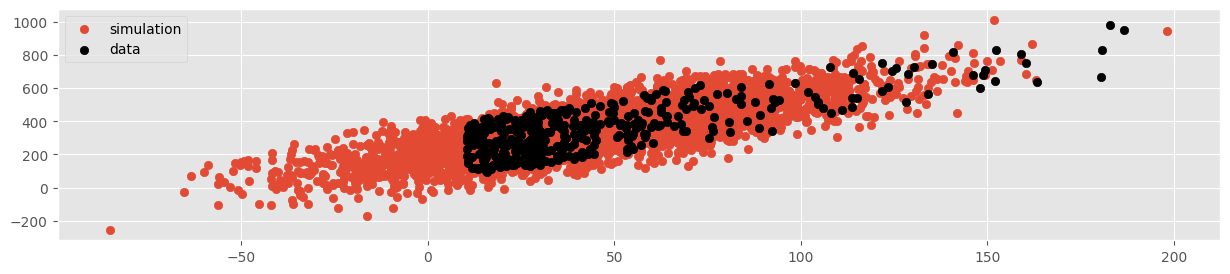

In [67]:
plt.scatter( samples[:,0], samples[:,1], label="simulation" )
plt.scatter( credit_data.Income, credit_data.Rating, c="black", label="data" )
plt.legend()

This looks quite different! However:

In [68]:
np.mean( samples, axis=0 )

array([ 45.13295302, 354.53145904])

In [69]:
credit_data.mean()

Income     45.218885
Rating    354.940000
dtype: float64

In [70]:
np.cov( samples.T )

array([[ 1271.48751354,  4423.2802777 ],
       [ 4423.2802777 , 24456.07565931]])

In [71]:
credit_data.cov()

,Income,Rating
Income,1242.158791,4315.492940
Rating,4315.492940,23939.560301


Similar mean and covariance! Our data just does not use all of the normal distribution, negative and too low values are not possible.

### e)

Select only samples in valid range:

In [72]:
samples = ppc.posterior_predictive.y_pred.values.reshape(-1,2)
samples = samples * stds.values + means.values
valid_inds = np.all( (samples > credit_data.min().values) & (samples < credit_data.max().values), axis=1 )
samples = samples[valid_inds]
samples.shape

(2660935, 2)

Subsample 4000:

In [73]:
inds = np.random.choice( np.arange( samples.shape[0] ), 4000 )
samples = samples[inds, :]
samples.shape

(4000, 2)

Scatter plot:

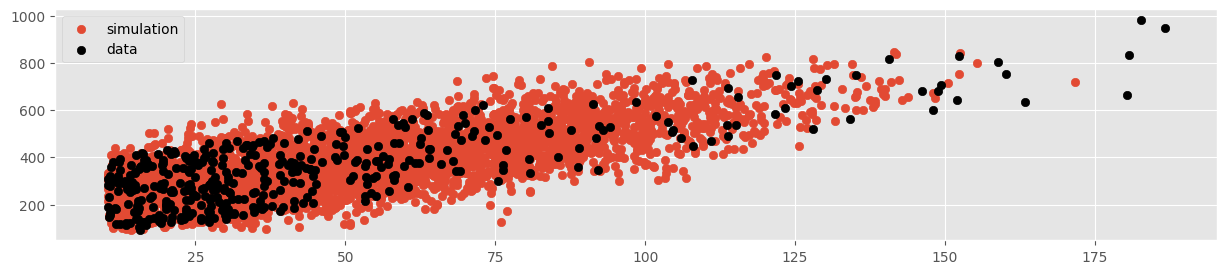

In [74]:
plt.scatter( samples[:,0], samples[:,1], label="simulation" )
plt.scatter( credit_data.Income, credit_data.Rating, c="black", label="data" )
plt.legend()

Voilà!